<a href="https://colab.research.google.com/github/aritanaoya/howling_canceler/blob/master/%E3%83%8F%E3%82%A6%E3%83%AA%E3%83%B3%E3%82%AF%E3%82%99%E3%82%AD%E3%83%A3%E3%83%B3%E3%82%BB%E3%83%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, shutil

os.getcwd()
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.9MB/s 


In [0]:
id = '1_f9QqOEv7CfDgN4jXGoQ-1Agpoah_lvu'  # 共有リンクで取得した id= より後の部分
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('ford8k.wav.zip')

In [8]:
#!unzip ford8k.wav
!ls
!pip install librosa==0.7

adc.json  ford8k.wav  ford8k.wav.zip  __MACOSX	README.md  sample_data
     |████████████████████████████████| 1.6MB 2.9MB/s 
  Created wheel for librosa: filename=librosa-0.7.0-cp36-none-any.whl size=1598345 sha256=b9707b3fc860cc90f6b25696f4407cc80e7f9ae2ad1aaa791a9148b24924df3c
  Stored in directory: /root/.cache/pip/wheels/49/1d/38/c8ad12fcad67569d8e730c3275be5e581bd589558484a0f881
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3


In [0]:
import librosa
import librosa.core as lc  
import numpy as np  
import scipy 
import IPython.display as ipd
import os
import matplotlib.pyplot as plt
import librosa.display

def load_wav(audio_path):  
  y, sr = librosa.load(audio, duration=10, sr = 8000)
  return y,sr
  
audio_path = "ford8k.wav"
load_wav(audio_path)

# Get the power spectrogram
S = np.abs(librosa.stft(y))**2


In [44]:


# Invert using Griffin-Lim
y_inv = librosa.core.griffinlim(S)
# Invert without estimating phase
y_istft = librosa.istft(S)


ipd.Audio(data=y_inv,rate=sr)


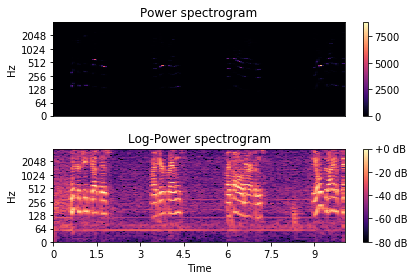

In [37]:
#音声プロット
#パワースペクトルと対数パワースペクトル
def plt_power_spec(S,sr):
  plt.figure()
  plt.subplot(2, 1, 1)
  librosa.display.specshow(S, sr=sr, y_axis='log')
  plt.colorbar()
  plt.title('Power spectrogram')
  plt.subplot(2, 1, 2)
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         sr=sr, y_axis='log', x_axis='time')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Log-Power spectrogram')
  plt.tight_layout()
  plt.show()

plt_power_spec(S,sr)

In [34]:
print(S.shape)

(1025, 157)


In [0]:
from keras import layers
from keras import models


model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu',
                       input_shape = (150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))


model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv

In [0]:
#モデルのコンパイル
from keras import optimizers

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

NameError: name 'train_dir' is not defined